# Credit Risk Assessment: LightGBM + SHAP

---

### Import Libraries and set Configurations

In [7]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import joblib
import optuna
import lightgbm as lgb
from scipy import sparse
from sklearn.metrics import roc_auc_score, classification_report, average_precision_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
import shap
import warnings
warnings.filterwarnings("ignore")

data = Path("../../data/processed")
random_state=42
n_trials = 60
early_stop = 200
top_n_shap = 50

### Load Data

In [2]:
X_train = sparse.load_npz(data/"X_train.npz")
X_test = sparse.load_npz(data/"X_test.npz")
y_train = pd.read_csv(data/"y_train.csv").squeeze("columns")
y_test = pd.read_csv(data/"y_test.csv").squeeze("columns")
pre = joblib.load(data / "preprocessor.joblib")
all_features = pre.get_feature_names_out()
print("train", X_train.shape, " test", X_test.shape)

train (1076248, 134)  test (269062, 134)


### Build Monotonic Constraint Vector

In [3]:
mono_map = {
    "num__dti"           : +1,
    "num__loan_to_income": +1,
    "num__installment_to_income": +1,
    "num__credit_age_months": -1,  
    "ord__grade"         : +1,      
    "ord__sub_grade"     : +1,
  
}
mono_vec = [mono_map.get(f, 0) for f in all_features]
print("Monotone constraints vector built (length =", len(mono_vec),")")

Monotone constraints vector built (length = 134 )


### Optuna Hyperparameter Search

In [5]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbose": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("lr", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("leaves", 31, 255, log=True),
        "max_depth": trial.suggest_int("depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data", 20, 400),
        "feature_fraction": trial.suggest_float("ff", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bf", 0.6, 1.0),
        "bagging_freq": 1,
        "lambda_l1": trial.suggest_float("l1", 0, 5),
        "lambda_l2": trial.suggest_float("l2", 0, 5),
        "class_weight": "balanced",
        "monotone_constraints": mono_vec,
        "force_col_wise": True,
        "random_state": random_state,
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    aucs = []
    for tr_idx, val_idx in cv.split(X_train, y_train):
        tr_data = lgb.Dataset(X_train[tr_idx], y_train.iloc[tr_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train.iloc[val_idx])
        bst = lgb.train(
            params,
            tr_data,
            num_boost_round=5000,
            valid_sets=[val_data],
            callbacks=[
        lgb.early_stopping(stopping_rounds=early_stop, verbose=False)
    ]
        )
        preds = bst.predict(X_train[val_idx])
        aucs.append(roc_auc_score(y_train.iloc[val_idx], preds))
    return np.mean(aucs)

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials, timeout=3600)
best_params = study.best_params
print("Best CV AUC:", study.best_value, "\nParams:", best_params)

[I 2025-06-05 12:37:06,593] A new study created in memory with name: no-name-cd60e212-af58-4fd5-a168-10a13f6e7b35
[I 2025-06-05 12:43:09,322] Trial 0 finished with value: 0.9619207347921559 and parameters: {'lr': 0.030710573677773714, 'leaves': 230, 'depth': 10, 'min_data': 248, 'ff': 0.6624074561769746, 'bf': 0.662397808134481, 'l1': 0.2904180608409973, 'l2': 4.330880728874676}. Best is trial 0 with value: 0.9619207347921559.
[I 2025-06-05 12:51:46,433] Trial 1 finished with value: 0.9615342846272318 and parameters: {'lr': 0.06054365855469249, 'leaves': 137, 'depth': 3, 'min_data': 389, 'ff': 0.9329770563201687, 'bf': 0.6849356442713105, 'l1': 0.9091248360355031, 'l2': 0.9170225492671691}. Best is trial 0 with value: 0.9619207347921559.
[I 2025-06-05 13:00:13,824] Trial 2 finished with value: 0.9619368827324927 and parameters: {'lr': 0.024878734419814436, 'leaves': 93, 'depth': 7, 'min_data': 130, 'ff': 0.8447411578889518, 'bf': 0.6557975442608167, 'l1': 1.4607232426760908, 'l2': 1.83

Best CV AUC: 0.9619949178065305 
Params: {'lr': 0.012151617026673379, 'leaves': 229, 'depth': 12, 'min_data': 327, 'ff': 0.7218455076693483, 'bf': 0.6390688456025535, 'l1': 3.4211651325607844, 'l2': 2.2007624686980067}


### Train LightGBM Model

In [8]:
best_params.update({
    "objective": "binary",
    "metric": "auc",
    "class_weight": "balanced",
    "monotone_constraints": mono_vec,
    "force_col_wise": True,
    "random_state": random_state,
})
gbm = lgb.LGBMClassifier(**best_params)
gbm.fit(X_train, y_train)
preds = gbm.predict_proba(X_test)[:, 1]
print("Hold-out AUC:", roc_auc_score(y_test, preds).round(4))
print(f"PR AUC: {average_precision_score(y_test, preds):.3f}")
print(classification_report(y_test, (preds>0.5).astype(int), digits=3))

Hold-out AUC: 0.9612
PR AUC: 0.872
              precision    recall  f1-score   support

           0      0.978     0.887     0.931    215350
           1      0.671     0.922     0.776     53712

    accuracy                          0.894    269062
   macro avg      0.825     0.904     0.854    269062
weighted avg      0.917     0.894     0.900    269062



### SHAP

SHAP summary saved


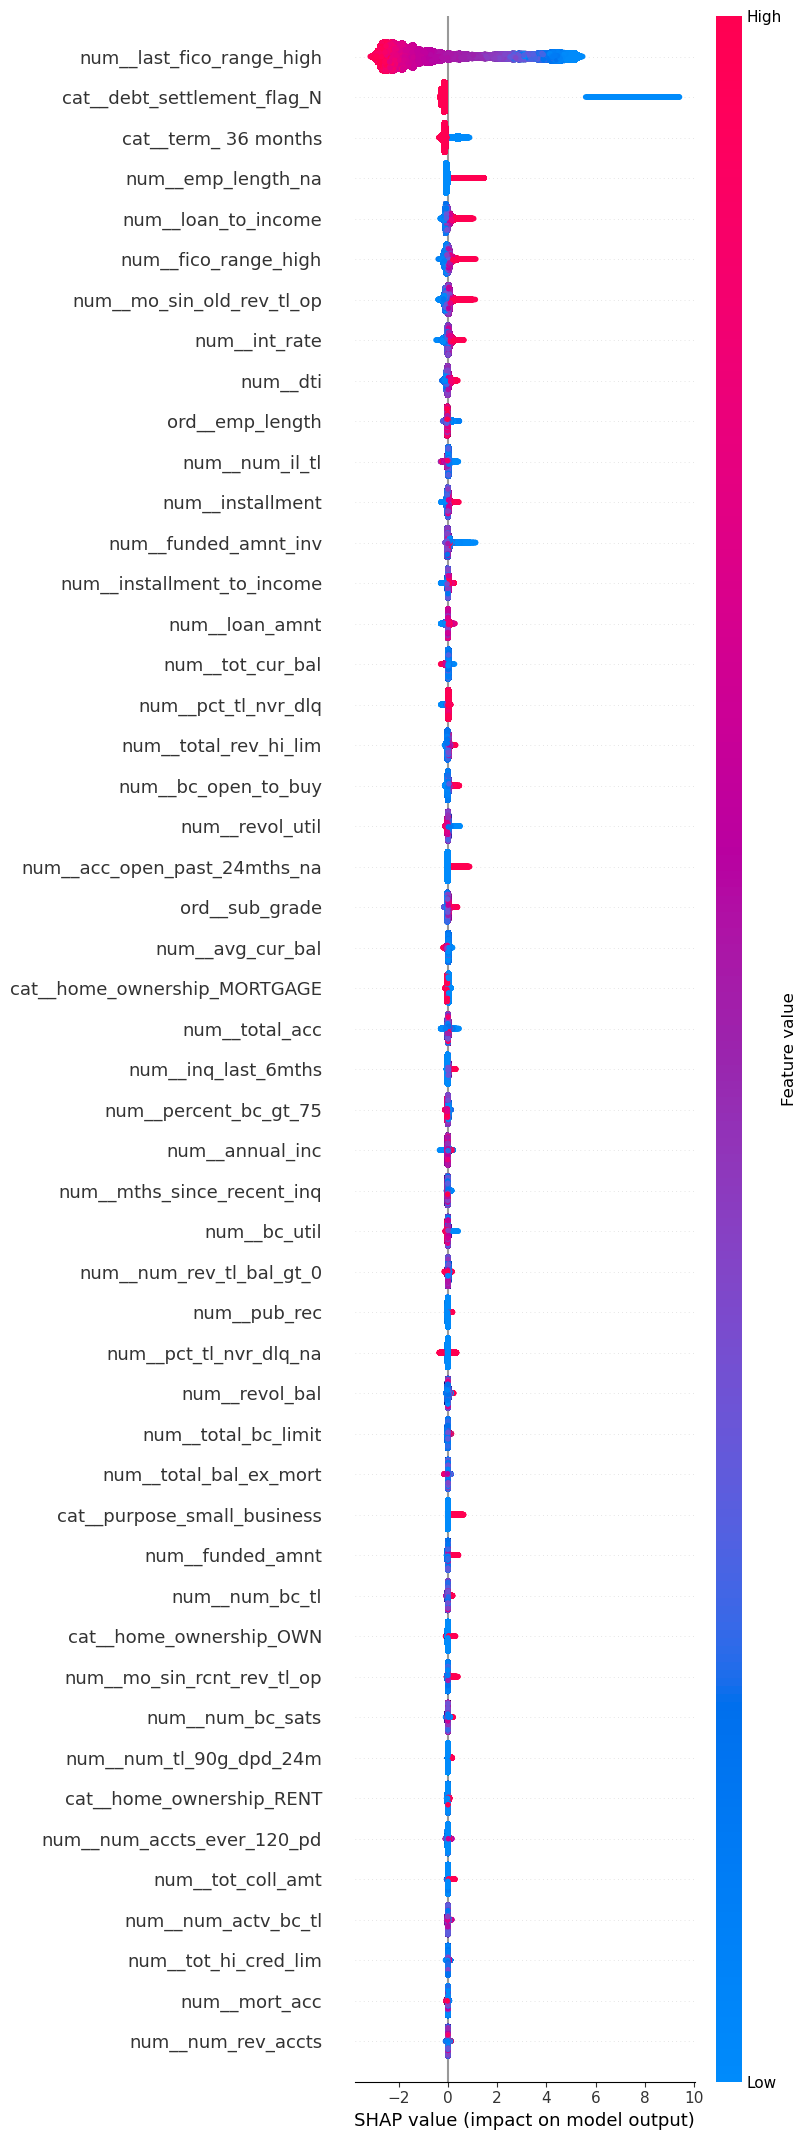

In [9]:
outputs = Path("../../outputs"); outputs.mkdir(exist_ok=True)
X_dense = X_train.toarray() if hasattr(X_train, "toarray") else np.array(X_train)
explainer = shap.TreeExplainer(gbm)
shap_vals = explainer.shap_values(X_dense, check_additivity=False)
if isinstance(shap_vals, list):
    shap_vals = shap_vals[0]
shap.summary_plot(shap_vals, X_dense, feature_names=all_features,
                  max_display=top_n_shap, show=False)
plt.savefig(outputs / "shap_summary_lightgbm.png", dpi=300, bbox_inches="tight")
print("SHAP summary saved")

In [10]:
mean_abs = np.abs(shap_vals).mean(axis=0)
top_idx  = np.argsort(mean_abs)[::-1][:top_n_shap]
sel_names = all_features[top_idx]
X_train_top = X_train[:, top_idx]
X_test_top  = X_test[:,  top_idx]
pd.Series(mean_abs[top_idx], index=sel_names).to_csv(outputs/"top_drivers.csv")
print(f"Top {top_n_shap} features extracted for surrogate")

Top 50 features extracted for surrogate


In [12]:
surrogate = LogisticRegressionCV(
    penalty="l1", solver="saga", class_weight="balanced",
    Cs=np.logspace(-2, 1, 8), cv=5, scoring="roc_auc",
    max_iter=300, n_jobs=-4, tol=1e-3, verbose=1, random_state=random_state
).fit(X_train_top, y_train)

sur_pred = surrogate.predict_proba(X_test_top)[:, 1]
print("Surrogate AUC:", roc_auc_score(y_test, sur_pred).round(4))

[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.


Epoch 1, change: 1
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.26641583
Epoch 2, change: 0.26574909
Epoch 2, change: 0.26559279
Epoch 2, change: 0.26575826
Epoch 2, change: 0.26540748
Epoch 3, change: 0.13100675
Epoch 3, change: 0.13106814
Epoch 3, change: 0.13080158
Epoch 3, change: 0.13078019
Epoch 3, change: 0.13064706
Epoch 4, change: 0.084151996
Epoch 4, change: 0.084337474
Epoch 4, change: 0.083999301
Epoch 4, change: 0.083976113
Epoch 4, change: 0.083958736
Epoch 5, change: 0.061340713
Epoch 5, change: 0.061424351
Epoch 5, change: 0.061228995
Epoch 5, change: 0.061226403
Epoch 5, change: 0.061227285
Epoch 6, change: 0.047411415
Epoch 6, change: 0.047414653
Epoch 6, change: 0.047328497
Epoch 6, change: 0.047294173
Epoch 6, change: 0.047390714
Epoch 7, change: 0.037811138
Epoch 7, change: 0.037842567
Epoch 7, change: 0.037743838
Epoch 7, change: 0.037713871
Epoch 7, change: 0.037781193
Epoch 8, change: 0.030953638
Epoch 8, change:

[Parallel(n_jobs=-4)]: Done   5 out of   5 | elapsed:  5.8min finished


Surrogate AUC: 0.9548


In [13]:
print("Surrogate AUC:", roc_auc_score(y_test, sur_pred).round(4))
print(classification_report(y_test, (sur_pred>0.5).astype(int), digits=3))
print(f"PR AUC: {average_precision_score(y_test, sur_pred):.3f}")

Surrogate AUC: 0.9548
              precision    recall  f1-score   support

           0      0.973     0.901     0.935    215350
           1      0.693     0.898     0.782     53712

    accuracy                          0.900    269062
   macro avg      0.833     0.899     0.859    269062
weighted avg      0.917     0.900     0.905    269062

PR AUC: 0.840
